In [1]:
#load necessary modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(1)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import h5py

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
# K.set_learning_phase(1)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

/home/apurvnit/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1 Load Dataset

In [2]:
data_train = pd.read_csv('data/sign_mnist_train.csv')
data_test = pd.read_csv('data/sign_mnist_test.csv')

In [3]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)

In [4]:
data_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
25741,2,185,186,187,187,187,186,185,186,185,...,203,202,201,201,199,197,196,195,194,192
2078,13,128,135,141,145,149,151,154,156,157,...,197,200,202,203,204,204,204,205,205,206
8015,16,61,74,83,94,100,102,104,111,119,...,32,23,18,22,27,49,66,64,66,65
14057,12,53,59,73,86,93,99,105,109,111,...,139,166,161,165,167,167,168,168,168,168
1853,10,129,113,106,84,105,42,69,82,84,...,126,127,127,129,110,61,72,78,73,78


In [5]:
data_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [6]:
data_test.size, data_train.size

(5630020, 21552175)

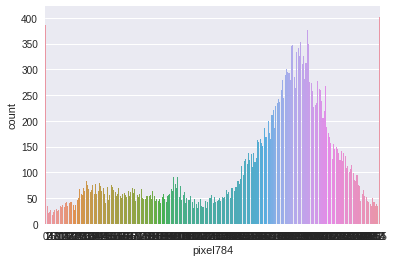

In [7]:
import seaborn as sns

ax = sns.countplot(data_train.iloc[:,-1],label="label")

This shows the intensity distribution in each image

In [7]:
X_train_orig_1 = data_train.iloc[:, 1:].values
Y_train_orig_1 = data_train.iloc[:, 0].values

In [8]:
X_test_orig_1 = data_test.iloc[:, 1:].values
Y_test_orig_1 = data_test.iloc[:, 0].values

In [13]:
print(X_train_orig_1.shape, X_test_orig_1.shape)

(27455, 784) (7172, 784)


# Data Preprocessing
## Restructuring the image

In [9]:
import cv2
from PIL import Image

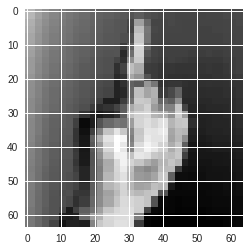

In [12]:
img1 = X_train_orig_1[0]
img2 = img1.reshape(28,28)
img3 = cv2.resize(img2, (64,64), interpolation = cv2.INTER_NEAREST).astype(np.float32)
plt.imshow(img3)

In [9]:
import cv2

def img_res(img):
    img1 = img.reshape(28,28)
    img2 = cv2.resize(img1, (64,64), interpolation = cv2.INTER_NEAREST).astype(np.float32)
    img3 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    return img3

In [10]:
X_train_orig_2 = np.apply_along_axis(img_res, 1 , X_train_orig_1)
X_test_orig_2 = np.apply_along_axis(img_res, 1 , X_test_orig_1)

In [11]:
print(X_train_orig_2.shape, X_test_orig_2.shape)

(27455, 64, 64, 3) (7172, 64, 64, 3)


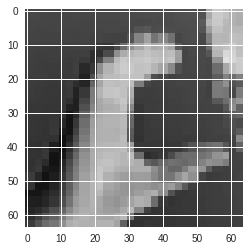

In [19]:
img1 = X_train_orig_2[0]
plt.imshow(img1)

In [20]:
print(Y_train_orig_1.shape)

(27455,)


# One hot encoding

In [12]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y].T
    return Y

In [13]:
Y_train = convert_to_one_hot(Y_train_orig_1, 26).T
Y_test = convert_to_one_hot(Y_test_orig_1, 26).T

### finalizing dependent and independent variables

In [14]:
X_train = X_train_orig_2
Y_train = Y_train

In [15]:
X_test = X_test_orig_2
Y_test = Y_test

# Visualization
This simple histogram shows the count of images of gestures in the training data for each number. This graphic is used to visualize if there is an unequal sample size among the digits. The sample size for each digit appear to be comparable. There is no issue of unequal sampling.

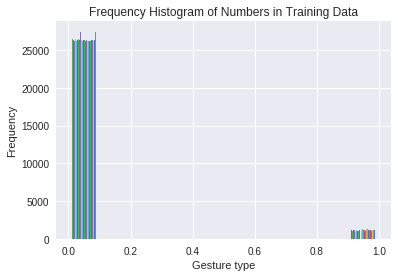

In [22]:
import matplotlib.pyplot as plt
plt.hist(Y_train)
plt.title("Frequency Histogram of Numbers in Training Data")
plt.xlabel("Gesture type")
plt.ylabel("Frequency")

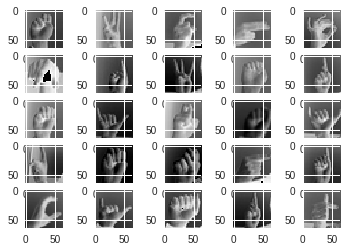

In [16]:
import math
# plot the first 25 images in the training set. 
f, ax = plt.subplots(5, 5)
# plot some 4s as an example
for i in range(1,26):
    data = X_train[i] #this is the first number
    n=math.ceil(i/5)-1
    m=[0,1,2,3,4]*5
    ax[m[i-1], n].imshow(data)
#     print(Y_train_orig[:,i][0],end=" ")

# Normalization

In [17]:
def normalization(x):
    return x/255

In [18]:
X_train = normalization(X_train)
X_test = normalization(X_test)

# Creating Model
using resnet-50 which has 50 layers and is used to predict much complex features in an image

In [20]:
def identity_block(X, f, filters, stage, block):

    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [21]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f,f), strides=(1,1), name=conv_name_base+'2b',padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s),padding='valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)

    
    X =  X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [22]:

def ResNet50(input_shape = (64, 64, 3), classes = 26):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL. Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D()(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [23]:
model = ResNet50(input_shape = (64, 64, 3), classes = 26)

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
import time

print("==================================================") 
    
print("Creating Model At: ","model.json") 
start_time = time.time()

json_model = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(json_model)

end_time = time.time()
total_time = end_time-start_time
print("Model Created: ",total_time, " seconds")

print("==================================================")

Creating Model At:  model.json
Model Created:  0.014238119125366211  seconds


In [32]:
print(model)
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes= True, show_layer_names = True)

In [19]:
from keras.models import model_from_json
model = None
with open('model.json') as json_file:
    model = model_from_json(json_file.read())
    json_file.close()

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.load_weights('hand_detection_weights.h5')

In [27]:
model.fit(X_train, Y_train, epochs = 5, batch_size = 32,validation_split=0.2)

Train on 21964 samples, validate on 5491 samples
Epoch 1/5
21964/21964 [==============================] - 2619s 119ms/step - loss: 0.0483 - acc: 0.9864 - val_loss: 0.0201 - val_acc: 0.9942
Epoch 2/5
21964/21964 [==============================] - 2069s 94ms/step - loss: 0.0272 - acc: 0.9919 - val_loss: 0.4023 - val_acc: 0.8811
Epoch 3/5
21964/21964 [==============================] - 1974s 90ms/step - loss: 0.0211 - acc: 0.9939 - val_loss: 1.0930e-04 - val_acc: 1.0000
Epoch 4/5
21964/21964 [==============================] - 2844s 129ms/step - loss: 2.3354e-04 - acc: 1.0000 - val_loss: 6.4082e-05 - val_acc: 1.0000
Epoch 5/5
21964/21964 [==============================] - 1975s 90ms/step - loss: 1.3370e-04 - acc: 1.0000 - val_loss: 2.4227e-05 - val_acc: 1.0000


In [28]:
model.save_weights('hand_detection_weights.h5')

In [22]:
model.evaluate(X_test, Y_test)

7172/7172 [==============================] - 155s 22ms/step


[0.2456481244274933, 0.9511991076408254]